# IEEE Credit Fraud Detection Report
Team 3 Massp 2021: \\
Phạm Đức Hải\
Lương Nguyên Cát\
Nguyễn Hải Dương

Link competition: https://www.kaggle.com/c/ieee-fraud-detection



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
import time
import datetime
import os, sys, gc, warnings, random
from xgboost import plot_importance
from matplotlib import pyplot
## Sklearn utilse
from sklearn.model_selection import KFold

## LGB
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import numpy as np, pandas as pd, os, gc
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
!pip install pandas-profiling[notebook,html]
from google.colab import drive
drive.mount("/content/drive")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
train_transaction = pd.read_csv('/content/drive/My Drive/IEEE/train_transaction.csv')
train_identity = pd.read_csv('/content/drive/My Drive/IEEE/train_identity.csv')
test_transaction= pd.read_csv('/content/drive/My Drive/IEEE/test_transaction.csv')
test_identity = pd.read_csv('/content/drive/My Drive/IEEE/test_identity.csv')

In [ ]:
def detect_num_cols_to_shrink(list_of_num_cols, dataframe):
 
    convert_to_int8 = []
    convert_to_int16 = []
    convert_to_int32 = []
    
    #  sadly the datatype float8 does not exist
    convert_to_float16 = []
    convert_to_float32 = []
    
    for col in list_of_num_cols:
        
        if dataframe[col].dtype in ['int', 'int8', 'int32', 'int64']:
            
            describe_object = dataframe[col].describe()
            minimum = describe_object[3]
            maximum = describe_object[7]
            diff = abs(maximum - minimum)

            if diff < 255:
                convert_to_int8.append(col)
                
            elif diff < 65535:
                convert_to_int16.append(col)
                
            elif diff < 4294967295:
                convert_to_int32.append(col)   
                
        elif dataframe[col].dtype in ['float', 'float16', 'float32', 'float64']:
            
            describe_object = dataframe[col].describe()
            minimum = describe_object[3]
            maximum = describe_object[7]
            diff = abs(maximum - minimum)

            if diff < 65535:
                convert_to_float16.append(col)
                
            elif diff < 4294967295:
                convert_to_float32.append(col) 
        
    list_of_lists = []
    list_of_lists.append(convert_to_int8)
    list_of_lists.append(convert_to_int16)
    list_of_lists.append(convert_to_int32)
    list_of_lists.append(convert_to_float16)
    list_of_lists.append(convert_to_float32)
    
    return list_of_lists

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train_transaction = reduce_mem_usage(train_transaction, verbose = True)
train_identity = reduce_mem_usage(train_identity,verbose = True)
test_transaction = reduce_mem_usage(test_transaction, verbose=True)
test_identity = reduce_mem_usage(test_identity,verbose = True)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


In [ ]:
pd.set_option('display.max_columns', None)

Tổng quát:
- **1. GIỚI THIỆU DATA:**
    - 1.1 Thông tin tổng quát dữ liệu
    - 1.2 Thông tin tổng quát về Target
    - 1.3 Metric đánh giá
- **2. KHAI PHÁ DỮ LIỆU**
    - 2.1 Dữ liệu Numerical
    - 2.2 Dữ liệu Categorical
    - 2.3 Tổng hợp các dữ liệu lấy làm Feature
- **3. FEATURE ENGINEERING**
    - 3.1 Xử lý dữ liệu numerical
    - 3.2 Xử lý dữ liệu Categorical
- **4. XÂY DỰNG MÔ HÌNH**
    - Mô hình XGBoost
    - Phương pháp Validate
    - UID

# **1. GIỚI THIỆU DATA**

- **1.1 Tổng quát dữ liệu vô**

- train_identity:
 - 23 loại Numerical
 - 14 categorical
 - 4 Boolean
 - Tổng quan: Nhiều biến thiếu dữ liệu

- train_transaction:
 - 356 loại Numerical 
 - 30 categorical
 - 8 loại boolean
 - Tổng quan: File hết 1.7gb, quá nhiều biến, cần giảm chiều dữ liệu


In [ ]:
train_transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  

In [ ]:
train_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN   
1    NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN   
2    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   
3    NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN   
4    0.0    0.0  100.0  NotFound    NaN -300.0  Found     Found  166.0   15.0   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  542.0  144.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  621.0  500.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
2  410.0  142.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
3  176.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
4  529.0  575.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   

      id_29             id_30                id_31  id_32      id_33  \
0  NotFound       Android 7.0  samsung browser 6.2   32.0  2220x1080   
1  NotFound        iOS 11.1.2   mobile safari 11.0   32.0   1334x750   
2     Found               NaN          chrome 62.0    NaN        NaN   
3  NotFound               NaN          chrome 62.0    NaN        NaN   
4     Found  Mac OS X 10_11_6          chrome 62.0   24.0   1280x800   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   
2             NaN     F     F     T     T    desktop   
3             NaN     F     F     T     T    desktop   
4  match_status:2     T     F     T     T    desktop   

                      DeviceInfo  
0  SAMSUNG SM-G892A Build/NRD90M  
1                     iOS Device  
2                        Windows  
3                            NaN  
4                          MacOS

In [ ]:
test_transaction.head()

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224       31.953125         W  10409  111.0   
1        3663550       18403263       49.000000         W   4272  111.0   
2        3663551       18403310      171.000000         W   4476  574.0   
3        3663552       18403310      285.000000         W  10989  360.0   
4        3663553       18403317       67.937500         W  18018  452.0   

   card3       card4  card5  card6  addr1  addr2   dist1  dist2 P_emaildomain  \
0  150.0        visa  226.0  debit  170.0   87.0     1.0    NaN     gmail.com   
1  150.0        visa  226.0  debit  299.0   87.0     4.0    NaN       aol.com   
2  150.0        visa  226.0  debit  472.0   87.0  2636.0    NaN   hotmail.com   
3  150.0        visa  166.0  debit  205.0   87.0    17.0    NaN     gmail.com   
4  150.0  mastercard  117.0  debit  264.0   87.0     6.0    NaN     gmail.com   

  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0           NaN  6.0  6.0  0.0  0.0  3.0  4.0  0.0  0.0  6.0  0.0  5.0  1.0   
1           NaN  3.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  2.0  0.0  1.0  1.0   
2           NaN  2.0  2.0  0.0  0.0  0.0  5.0  0.0  0.0  4.0  0.0  2.0  0.0   
3           NaN  5.0  2.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  2.0  0.0   
4           NaN  6.0  6.0  0.0  0.0  2.0  5.0  0.0  0.0  5.0  0.0  6.0  0.0   

     C13  C14     D1     D2    D3     D4    D5  D6  D7  D8  D9    D10    D11  \
0  115.0  6.0  419.0  419.0  27.0  398.0  27.0 NaN NaN NaN NaN  418.0  203.0   
1   12.0  2.0  149.0  149.0   7.0  634.0   7.0 NaN NaN NaN NaN  231.0  634.0   
2   22.0  2.0  137.0  137.0  10.0   97.0  10.0 NaN NaN NaN NaN  136.0  136.0   
3    7.0  4.0   42.0   42.0  41.0  242.0  41.0 NaN NaN NaN NaN  242.0  242.0   
4   14.0  6.0   22.0   22.0   0.0   22.0   0.0 NaN NaN NaN NaN   22.0   22.0   

   D12  D13  D14    D15 M1 M2 M3   M4   M5 M6   M7   M8   M9   V1   V2   V3  \
0  NaN  NaN  NaN  409.0  T  T  F  NaN  NaN  F    T    T    T  1.0  1.0  1.0   
1  NaN  NaN  NaN  634.0  T  F  F   M0  NaN  F  NaN  NaN  NaN  1.0  1.0  1.0   
2  NaN  NaN  NaN   97.0  T  T  F   M0    F  F    F    F    F  1.0  1.0  1.0   
3  NaN  NaN  NaN  242.0  T  T  T  NaN  NaN  T  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN   22.0  T  T  T  NaN  NaN  F    F    T    T  1.0  1.0  1.0   

    V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   

   V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  0.0  0.0  2.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
4  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   

   V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  \
0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
1  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
2  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
3  0.0  2.0  2.0  2.0  2.0  0.0  0.0  1.0  0.0  0.0  2.0  2.0  2.0  2.0  1.0   
4  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   

   V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  \
0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0

In [ ]:
test_identity.head()

TransactionID  id-01     id-02  id-03  id-04  id-05  id-06  id-07  id-08  \
0        3663586  -45.0  280290.0    NaN    NaN    0.0    0.0    NaN    NaN   
1        3663588    0.0    3579.0    0.0    0.0    0.0    0.0    NaN    NaN   
2        3663597   -5.0  185210.0    NaN    NaN    1.0    0.0    NaN    NaN   
3        3663601  -45.0  252944.0    0.0    0.0    0.0    0.0    NaN    NaN   
4        3663602  -95.0  328680.0    NaN    NaN    7.0  -33.0    NaN    NaN   

   id-09  id-10  id-11     id-12  id-13  id-14  id-15     id-16  id-17  id-18  \
0    NaN    NaN  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0   
1    0.0    0.0  100.0     Found    NaN -300.0  Found     Found  166.0    NaN   
2    NaN    NaN  100.0  NotFound   52.0 -360.0    New  NotFound  225.0    NaN   
3    0.0    0.0  100.0  NotFound   27.0    NaN  Found     Found  225.0   15.0   
4    NaN    NaN  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0   

   id-19  id-20  id-21  id-22 id-23  id-24  id-25  id-26 id-27  id-28  \
0  427.0  563.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  542.0  368.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
2  271.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
3  427.0  563.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
4  567.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   

      id-29          id-30                    id-31  id-32     id-33  \
0  NotFound            NaN  chrome 67.0 for android    NaN       NaN   
1     Found  Android 6.0.1  chrome 67.0 for android   24.0  1280x720   
2  NotFound            NaN       ie 11.0 for tablet    NaN       NaN   
3     Found            NaN  chrome 67.0 for android    NaN       NaN   
4  NotFound            NaN  chrome 67.0 for android    NaN       NaN   

            id-34 id-35 id-36 id-37 id-38 DeviceType  \
0             NaN     F     F     T     F     mobile   
1  match_status:2     T     F     T     T     mobile   
2             NaN     F     T     T     F    desktop   
3             NaN     F     F     T     F     mobile   
4             NaN     F     F     T     F     mobile   

                    DeviceInfo  
0  MYA-L13 Build/HUAWEIMYA-L13  
1         LGLS676 Build/MXB48T  
2                  Trident/7.0  
3  MYA-L13 Build/HUAWEIMYA-L13  
4         SM-G9650 Build/R16NW

In [ ]:
#gom 2 dataset lại thành 1 theo transactionID
final_train = pd.merge(train_transaction, train_identity, how = 'left', on = 'TransactionID')

final_test = pd.merge(test_transaction, test_identity, how = 'left', on = 'TransactionID')


In [ ]:
del train_transaction
del train_identity
del test_transaction
del test_identity

In [ ]:
print(final_train.shape)
print(final_test.shape)

(590540, 434)
(506691, 433)


 **Kiểm tra giữa 2 file có các cột nào khác nhau**

We have observed there exist difference style in column name. Therefore, need to solve this issue.

In [ ]:
def different_columns(traincols, testcols):
    
    for i in traincols:
        
        if i not in testcols:
            
            print(i)
            
different_columns(final_train.columns, final_test.columns)

In [ ]:
final_test = final_test.rename(columns = {"id-01": "id_01", "id-02": "id_02", "id-03": "id_03", 
                            "id-06": "id_06", "id-05": "id_05", "id-04": "id_04", 
                            "id-07": "id_07", "id-08": "id_08", "id-09": "id_09", 
                            "id-10": "id_10", "id-11": "id_11", "id-12": "id_12", 
                            "id-15": "id_15", "id-14": "id_14", "id-13": "id_13", 
                            "id-16": "id_16", "id-17": "id_17", "id-18": "id_18", 
                            "id-21": "id_21", "id-20": "id_20", "id-19": "id_19", 
                            "id-22": "id_22", "id-23": "id_23", "id-24": "id_24", 
                            "id-27": "id_27", "id-26": "id_26", "id-25": "id_25", 
                            "id-28": "id_28", "id-29": "id_29", "id-30": "id_30", 
                            "id-31": "id_31", "id-32": "id_32", "id-33": "id_33", 
                            "id-34": "id_34", "id-35": "id_35", "id-36": "id_36", 
                            "id-37": "id_37", "id-38": "id_38"})
final_test.head()

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224       31.953125         W  10409  111.0   
1        3663550       18403263       49.000000         W   4272  111.0   
2        3663551       18403310      171.000000         W   4476  574.0   
3        3663552       18403310      285.000000         W  10989  360.0   
4        3663553       18403317       67.937500         W  18018  452.0   

   card3       card4  card5  card6  addr1  addr2   dist1  dist2 P_emaildomain  \
0  150.0        visa  226.0  debit  170.0   87.0     1.0    NaN     gmail.com   
1  150.0        visa  226.0  debit  299.0   87.0     4.0    NaN       aol.com   
2  150.0        visa  226.0  debit  472.0   87.0  2636.0    NaN   hotmail.com   
3  150.0        visa  166.0  debit  205.0   87.0    17.0    NaN     gmail.com   
4  150.0  mastercard  117.0  debit  264.0   87.0     6.0    NaN     gmail.com   

  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0           NaN  6.0  6.0  0.0  0.0  3.0  4.0  0.0  0.0  6.0  0.0  5.0  1.0   
1           NaN  3.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  2.0  0.0  1.0  1.0   
2           NaN  2.0  2.0  0.0  0.0  0.0  5.0  0.0  0.0  4.0  0.0  2.0  0.0   
3           NaN  5.0  2.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  2.0  0.0   
4           NaN  6.0  6.0  0.0  0.0  2.0  5.0  0.0  0.0  5.0  0.0  6.0  0.0   

     C13  C14     D1     D2    D3     D4    D5  D6  D7  D8  D9    D10    D11  \
0  115.0  6.0  419.0  419.0  27.0  398.0  27.0 NaN NaN NaN NaN  418.0  203.0   
1   12.0  2.0  149.0  149.0   7.0  634.0   7.0 NaN NaN NaN NaN  231.0  634.0   
2   22.0  2.0  137.0  137.0  10.0   97.0  10.0 NaN NaN NaN NaN  136.0  136.0   
3    7.0  4.0   42.0   42.0  41.0  242.0  41.0 NaN NaN NaN NaN  242.0  242.0   
4   14.0  6.0   22.0   22.0   0.0   22.0   0.0 NaN NaN NaN NaN   22.0   22.0   

   D12  D13  D14    D15 M1 M2 M3   M4   M5 M6   M7   M8   M9   V1   V2   V3  \
0  NaN  NaN  NaN  409.0  T  T  F  NaN  NaN  F    T    T    T  1.0  1.0  1.0   
1  NaN  NaN  NaN  634.0  T  F  F   M0  NaN  F  NaN  NaN  NaN  1.0  1.0  1.0   
2  NaN  NaN  NaN   97.0  T  T  F   M0    F  F    F    F    F  1.0  1.0  1.0   
3  NaN  NaN  NaN  242.0  T  T  T  NaN  NaN  T  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN   22.0  T  T  T  NaN  NaN  F    F    T    T  1.0  1.0  1.0   

    V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   

   V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  0.0  0.0  2.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
4  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   

   V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  \
0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
1  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
2  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
3  0.0  2.0  2.0  2.0  2.0  0.0  0.0  1.0  0.0  0.0  2.0  2.0  2.0  2.0  1.0   
4  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   

   V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  \
0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0

**Kiểm tra lại train và test có còn cột khác không**

In [ ]:
different_columns(final_train.columns, final_test.columns)

isFraud


### **1.2 Thông tin tổng quát Target**

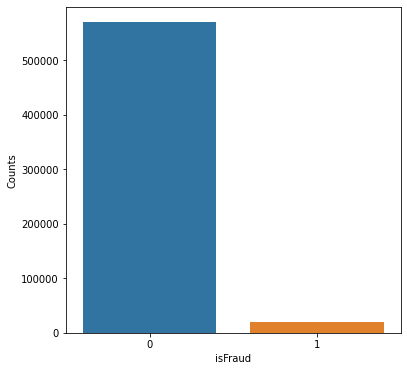

In [ ]:
#plot fraud and not fraud
plt_target = plt.figure(figsize = (6,6))
sns.barplot([0 ,1],final_train['isFraud'].value_counts().values)
plt.xlabel("isFraud")
plt.ylabel("Counts")
plt.show()

 ### **1.3 Thông tin tổng quát Metric** ###

 - Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.
 - Nên sử dụng F1 score, tìm Precision, Recall, Confusion Matrix
 - Nên dùng model nào để dễ tối ưu AUC???




# **2. KHAI PHÁ DỮ LIỆU**

### **Check Nan trong Data:** ##

In [ ]:
def getNulls(data):
    
    total = data.isnull().sum()
    percent = data.isnull().sum() / data.isnull().count()
    missing_data = pd.concat([total, percent], axis = 1, keys = ['total', 'precent'])
    
    return missing_data

In [ ]:
missing_data_train = getNulls(final_train)
missing_data_train.head(434).T

TransactionID  isFraud  TransactionDT  TransactionAmt  ProductCD  \
total              0.0      0.0            0.0             0.0        0.0   
precent            0.0      0.0            0.0             0.0        0.0   

         card1        card2       card3       card4        card5       card6  \
total      0.0  8933.000000  1565.00000  1577.00000  4259.000000  1571.00000   
precent    0.0     0.015127     0.00265     0.00267     0.007212     0.00266   

                addr1         addr2          dist1          dist2  \
total    65706.000000  65706.000000  352271.000000  552913.000000   
precent      0.111264      0.111264       0.596524       0.936284   

         P_emaildomain  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8  \
total     94456.000000  453249.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
precent       0.159949       0.767516  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

          C9  C10  C11  C12  C13  C14           D1             D2  \
total    0.0  0.0  0.0  0.0  0.0  0.0  1269.000000  280797.000000   
precent  0.0  0.0  0.0  0.0  0.0  0.0     0.002149       0.475492   

                    D3             D4             D5             D6  \
total    262878.000000  168922.000000  309841.000000  517353.000000   
precent       0.445149       0.286047       0.524674       0.876068   

                    D7             D8             D9           D10  \
total    551623.000000  515614.000000  515614.000000  76022.000000   
precent       0.934099       0.873123       0.873123      0.128733   

                   D11           D12            D13            D14  \
total    279287.000000  525823.00000  528588.000000  528353.000000   
precent       0.472935       0.89041       0.895093       0.894695   

                  D15             M1             M2             M3  \
total    89113.000000  271100.000000  271100.000000  271100.000000   
precent      0.150901       0.459071       0.459071       0.459071   

                    M4             M5             M6             M7  \
total    281444.000000  350482.000000  169360.000000  346265.000000   
precent       0.476588       0.593494       0.286788       0.586353   

                    M8             M9             V1             V2  \
total    346252.000000  346252.000000  279287.000000  279287.000000   
precent       0.586331       0.586331       0.472935       0.472935   

                    V3             V4             V5             V6  \
total    279287.000000  279287.000000  279287.000000  279287.000000   
precent       0.472935       0.472935       0.472935       0.472935   

                    V7             V8             V9            V10  \
total    279287.000000  279287.000000  279287.000000  279287.000000   
precent       0.472935       0.472935       0.472935       0.472935   

                   V11           V12           V13           V14  \
total    279287.000000  76073.000000  76073.000000  76073.000000   
precent       0.472935      0.128819      0.128819      0.128819   

                  V15           V16           V17           V18           V19  \
total    76073.000000  76073.000000  76073.000000  76073.000000  76073.000000   
precent      0.128819      0.128819      0.128819      0.128819      0.128819   

                  V20           V21           V22           V23           V24  \
total    76073.000000  76073.000000  76073.000000  76073.000000  76073.000000   
precent      0.128819      0.128819      0.128819      0.128819      0.128819   

                  V25           V26           V27           V28           V29  \
total    76073.000000  76073.000000  76073.000000  76073.000000  76073.000000   
precent      0.128819      0.128819      0.128819      0.128819      0.128819   

                  V30           V31           V32           V33           V34  \
total    76073.000000  76073.000000  76073.000000  76073.000000  76073.000000   
precent      0.128819      0.128819      0.128819      0.128819      0.128

### **Tổng kết về Nan:** ###
- Nhiều cột có Nan hơn 25% **=>** Nếu bỏ thì sẽ mất khá nhiều data
- Ít dữ liệu nên **fill Nan bằng số ảo** (-999 hoặc -1)
- Có nhiều cột **mang thông tin đặc trưng** (card1-6 là số thẻ, addr1-2 là số nhà). **Fill bằng mean sẽ không có ý nghĩa**

In [ ]:
del missing_data_train

## **2.1 Dữ liệu Numerical**:

In [ ]:
numerical = final_train.select_dtypes(include='number')
numerical

TransactionID  isFraud  TransactionDT  TransactionAmt  card1  card2  \
0             2987000        0          86400       68.500000  13926    NaN   
1             2987001        0          86401       29.000000   2755  404.0   
2             2987002        0          86469       59.000000   4663  490.0   
3             2987003        0          86499       50.000000  18132  567.0   
4             2987004        0          86506       50.000000   4497  514.0   
...               ...      ...            ...             ...    ...    ...   
590535        3577535        0       15811047       49.000000   6550    NaN   
590536        3577536        0       15811049       39.500000  10444  225.0   
590537        3577537        0       15811079       30.953125  12037  595.0   
590538        3577538        0       15811088      117.000000   7826  481.0   
590539        3577539        0       15811131      280.000000  15066  170.0   

        card3  card5  addr1  addr2  dist1  dist2   C1   C2   C3   C4   C5  \
0       150.0  142.0  315.0   87.0   19.0    NaN  1.0  1.0  0.0  0.0  0.0   
1       150.0  102.0  325.0   87.0    NaN    NaN  1.0  1.0  0.0  0.0  0.0   
2       150.0  166.0  330.0   87.0  287.0    NaN  1.0  1.0  0.0  0.0  0.0   
3       150.0  117.0  476.0   87.0    NaN    NaN  2.0  5.0  0.0  0.0  0.0   
4       150.0  102.0  420.0   87.0    NaN    NaN  1.0  1.0  0.0  0.0  0.0   
...       ...    ...    ...    ...    ...    ...  ...  ...  ...  ...  ...   
590535  150.0  226.0  272.0   87.0   48.0    NaN  2.0  1.0  0.0  0.0  1.0   
590536  150.0  224.0  204.0   87.0    NaN    NaN  1.0  1.0  0.0  0.0  0.0   
590537  150.0  224.0  231.0   87.0    NaN    NaN  1.0  1.0  0.0  0.0  1.0   
590538  150.0  224.0  387.0   87.0    3.0    NaN  1.0  1.0  0.0  0.0  0.0   
590539  150.0  102.0  299.0   87.0    NaN    NaN  2.0  1.0  0.0  0.0  1.0   

         C6   C7   C8   C9  C10  C11  C12   C13  C14     D1     D2    D3  \
0       1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   
1       1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   
2       1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   
3       4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0   
4       1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   
...     ...  ...  ...  ...  ...  ...  ...   ...  ...    ...    ...   ...   
590535  0.0  0.0  0.0  2.0  0.0  1.0  0.0   3.0  2.0   29.0   29.0  30.0   
590536  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   
590537  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   
590538  3.0  0.0  0.0  2.0  0.0  1.0  1.0   5.0  1.0   22.0   22.0   0.0   
590539  1.0  0.0  0.0  2.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   0.0   

          D4   D5  D6  D7  D8  D9   D10    D11  D12  D13  D14    D15   V1  \
0        NaN  NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN    0.0  1.0   
1        0.0  NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN    0.0  NaN   
2        0.0  NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN  315.0  1.0   
3       94.0  0.0 NaN NaN NaN NaN  84.0    NaN  NaN  NaN  NaN  111.0  NaN   
4        NaN  NaN NaN NaN NaN NaN   NaN    NaN  NaN  NaN  NaN    NaN  NaN   
...      ...  ...  ..  ..  ..  ..   ...    ...  ...  ...  ...    ...  ...   
590535   NaN  NaN NaN NaN NaN NaN  56.0   56.0  NaN  NaN  NaN   56.0  1.0   
590536   0.0  NaN NaN NaN NaN NaN   0.0    0.0  NaN  NaN  NaN    0.0  1.0   
590537   0.0  NaN NaN NaN NaN NaN   0.0    0.0  NaN  NaN  NaN    0.0  1.0   
590538  22.0  0.0 NaN NaN NaN NaN  22.0   22.0  NaN  NaN  NaN   22.0  1.0   
590539   1.0  0.0 NaN NaN NaN NaN   1.0    0.0  NaN  NaN  NaN    1.0  1.0   

         V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  \
0       1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0   
1       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0   
2       1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc. 
- addr: address
- dist: distance
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. 
- D1-D15: timedelta, such as days between previous transaction, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
- idxx: Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

### **Vesta features**: ###
The V columns share a “lot” of correlation and a large number of Nan’s. The goal of this step is to find “similar” columns based on number of “NaN’s”, and Correlation>0.75. This process is automated for all the different NaN groups, using a script. The method is explained as below:

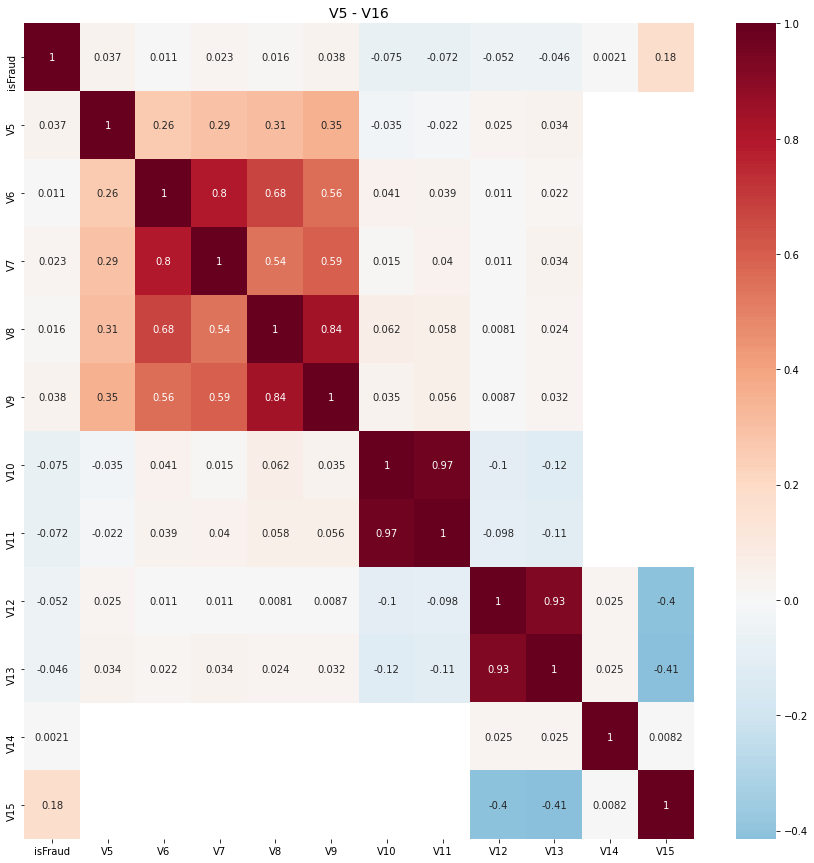

In [ ]:
def make_corr(Vs,Vtitle=''):
    cols = ['isFraud'] + Vs
    plt.figure(figsize=(15,15))
    sns.heatmap(numerical[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
    if Vtitle!='': plt.title(Vtitle,fontsize=14)
    else: plt.title(Vs[0]+' - '+Vs[-1],fontsize=14)
    plt.show()
Vs = ['V'+str(i) for i in range(5,16)]
Vtitle = 'V5 - V16'
make_corr(Vs,Vtitle)

### **idxx** ###

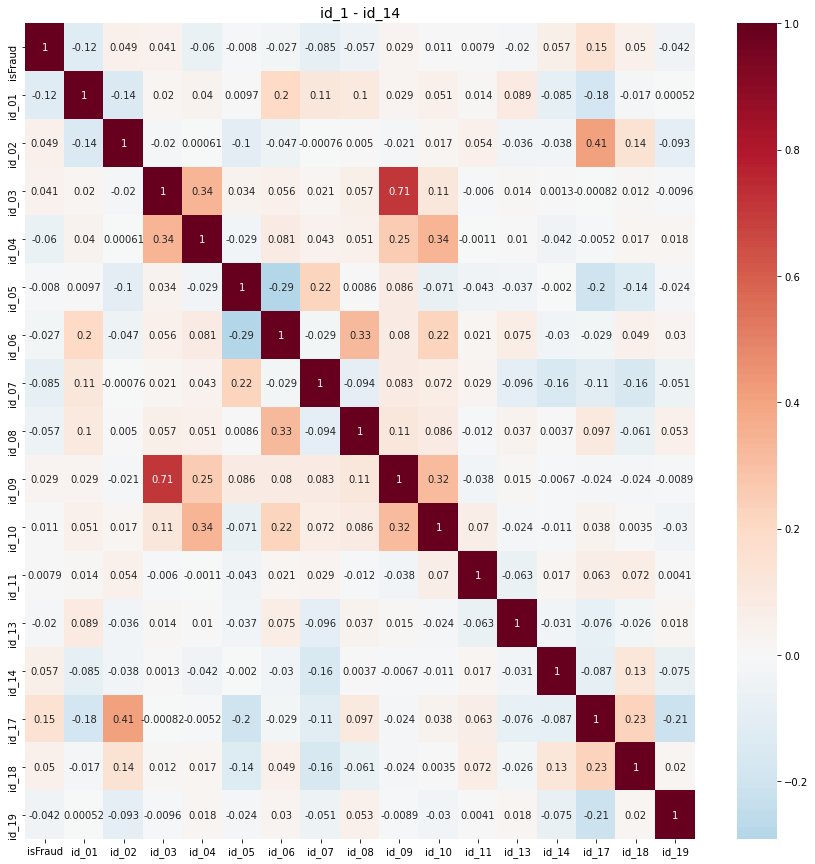

In [ ]:
Vs = ['id_0'+str(i) for i in range(1,10)]
Vs+= ['id_'+str(10)]
Vs+= ['id_'+str(11)]
Vs+= ['id_'+str(13)]
Vs+= ['id_'+str(14)]
Vs+= ['id_'+str(17)]
Vs+= ['id_'+str(18)]
Vs+= ['id_'+str(19)]
Vtitle = 'id_1 - id_14'
make_corr(Vs,Vtitle)

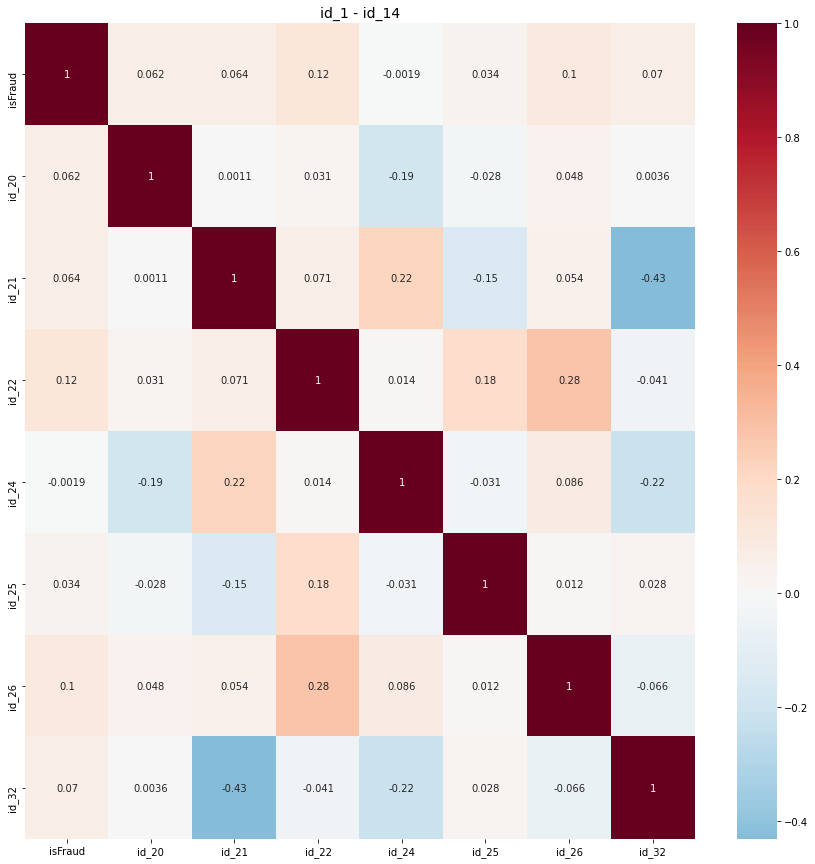

In [ ]:
Vs = ['id_'+str(i) for i in range(20,23)]
Vs += ['id_'+str(i) for i in range(24,27)]
Vs+= ['id_'+str(32)]
Vtitle = 'id_1 - id_14'
make_corr(Vs,Vtitle)

### **D1-D15:** ###
D1 column is known from the discussions to be “days since the client credit card began”. Subtracting this value from the “Transaction Day” will result in CONSTANT values per client. D1n is the created column after subtraction.

We do the same for all D columns irrespective, and allow the model to decide what is important and what is not. Following is an example of an “assumed client-variable set”. Notice how the D1n columns are constant and the D1 columns increase over time, when the data is sorted on TransactionDT.

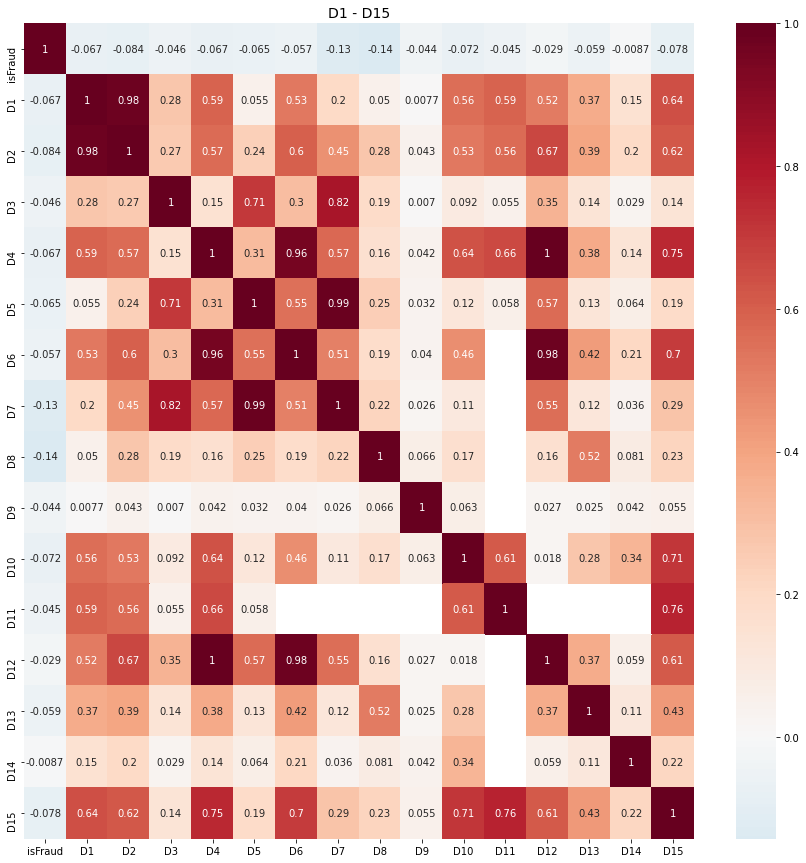

In [ ]:
Vs = ['D'+str(i) for i in range(1,16)]
Vtitle = 'D1 - D15'
make_corr(Vs,Vtitle)

### **Card1, 2, 3, 5:** ###
payment card information, such as card type, card category, issue bank, country, etc.

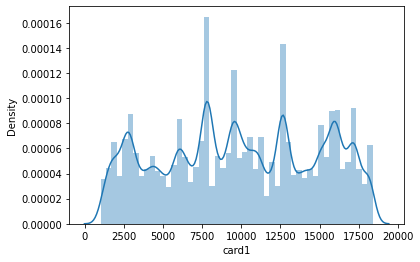

In [ ]:
sns.distplot(a = numerical['card1'])

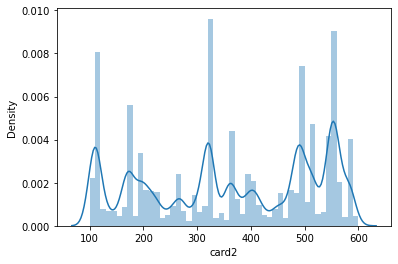

In [ ]:
sns.distplot(a = numerical['card2'])

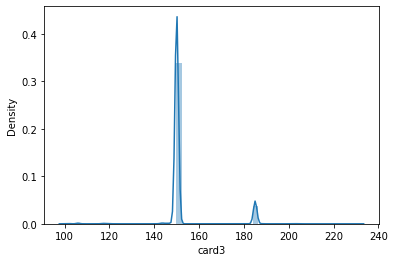

In [ ]:
sns.distplot(a = numerical['card3'])

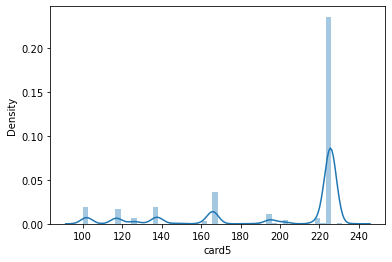

In [ ]:
sns.distplot(a = numerical['card5'])

### **TransactionAmt**: ###

In [ ]:
numerical['TransactionAmt'].describe()

count    590540.000000
mean               NaN
std                NaN
min           0.250977
25%          43.312500
50%          68.750000
75%         125.000000
max       31936.000000
Name: TransactionAmt, dtype: float64

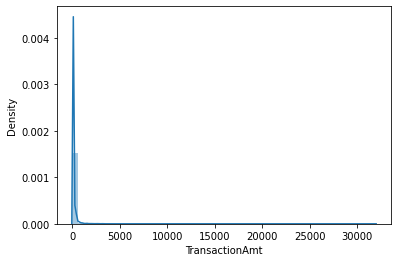

In [ ]:
sns.distplot(a = numerical['TransactionAmt'])

Xử dụng Log1P để đưa về normal distribution

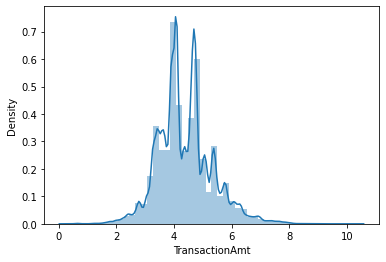

In [ ]:
sns.distplot(a= np.log1p(numerical['TransactionAmt']))

There are many categorical columns, that would allow for better models when split. For example, we have “TransactionAmt”, which allows for the split: “dollars” and “cents”. cents could be a proxy for identifying if the transaction is from another country than US. Possibly there could be a pattern on how frauds happen with “cents”. The “split” is done using the following function:

In [ ]:
 def split_cols(df, col):
  df['cents'] = df[col].mod(1)
  df[col] = df[col].floordiv(1)

In [ ]:
split_cols(numerical,'TransactionAmt')

In [ ]:
numerical[['TransactionAmt','cents']]

TransactionAmt     cents
0                 68.0  0.500000
1                 29.0  0.000000
2                 59.0  0.000000
3                 50.0  0.000000
4                 50.0  0.000000
...                ...       ...
590535            49.0  0.000000
590536            39.0  0.500000
590537            30.0  0.953125
590538           117.0  0.000000
590539           280.0  0.000000

[590540 rows x 2 columns]

### **Distance**: ###
distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.

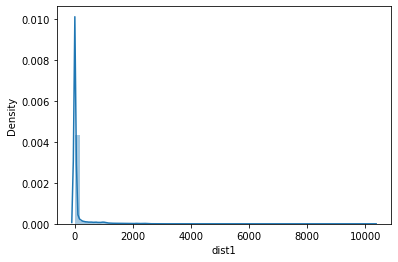

In [ ]:
sns.distplot(a = numerical['dist1'])

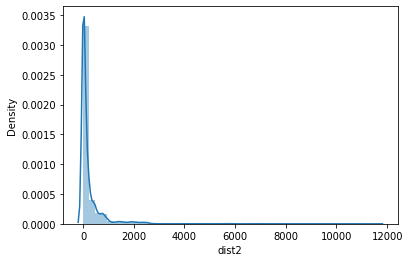

In [ ]:
sns.distplot(a = numerical['dist2'])

## **2.2 Dữ liệu Categorical** ##

In [ ]:
#coi thử categorical
categorical = final_train.select_dtypes(exclude='number')
categorical

ProductCD       card4   card6 P_emaildomain R_emaildomain   M1   M2  \
0              W    discover  credit           NaN           NaN    T    T   
1              W  mastercard  credit     gmail.com           NaN  NaN  NaN   
2              W        visa   debit   outlook.com           NaN    T    T   
3              W  mastercard   debit     yahoo.com           NaN  NaN  NaN   
4              H  mastercard  credit     gmail.com           NaN  NaN  NaN   
...          ...         ...     ...           ...           ...  ...  ...   
590535         W        visa   debit           NaN           NaN    T    T   
590536         W  mastercard   debit     gmail.com           NaN    T    F   
590537         W  mastercard   debit     gmail.com           NaN    T    F   
590538         W  mastercard   debit       aol.com           NaN    T    T   
590539         W  mastercard  credit     gmail.com           NaN    T    F   

         M3   M4   M5   M6   M7   M8   M9     id_12 id_15     id_16 id_23  \
0         T   M2    F    T  NaN  NaN  NaN       NaN   NaN       NaN   NaN   
1       NaN   M0    T    T  NaN  NaN  NaN       NaN   NaN       NaN   NaN   
2         T   M0    F    F    F    F    F       NaN   NaN       NaN   NaN   
3       NaN   M0    T    F  NaN  NaN  NaN       NaN   NaN       NaN   NaN   
4       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NotFound   New  NotFound   NaN   
...     ...  ...  ...  ...  ...  ...  ...       ...   ...       ...   ...   
590535    T   M0    T    F    F    F    T       NaN   NaN       NaN   NaN   
590536    F   M0    F    T    F    F    F       NaN   NaN       NaN   NaN   
590537    F  NaN  NaN    T  NaN  NaN  NaN       NaN   NaN       NaN   NaN   
590538    T   M0    F    T  NaN  NaN  NaN       NaN   NaN       NaN   NaN   
590539    F  NaN  NaN    T    F    F    F       NaN   NaN       NaN   NaN   

       id_27 id_28     id_29        id_30                id_31      id_33  \
0        NaN   NaN       NaN          NaN                  NaN        NaN   
1        NaN   NaN       NaN          NaN                  NaN        NaN   
2        NaN   NaN       NaN          NaN                  NaN        NaN   
3        NaN   NaN       NaN          NaN                  NaN        NaN   
4        NaN   New  NotFound  Android 7.0  samsung browser 6.2  2220x1080   
...      ...   ...       ...          ...                  ...        ...   
590535   NaN   NaN       NaN          NaN                  NaN        NaN   
590536   NaN   NaN       NaN          NaN                  NaN        NaN   
590537   NaN   NaN       NaN          NaN                  NaN        NaN   
590538   NaN   NaN       NaN          NaN                  NaN        NaN   
590539   NaN   NaN       NaN          NaN                  NaN        NaN   

                 id_34 id_35 id_36 id_37 id_38 DeviceType  \
0                  NaN   NaN   NaN   NaN   NaN        NaN   
1                  NaN   NaN   NaN   NaN   NaN        NaN   
2                  NaN   NaN   NaN   NaN   NaN        NaN   
3                  NaN   NaN   NaN   NaN   NaN        NaN   
4       match_status:2     T     F     T     T     mobile   
...                ...   ...   ...   ...   ...        ...   
590535             NaN   NaN   NaN   NaN   NaN        NaN   
590536             NaN   NaN   NaN   NaN   NaN        NaN   
590537             NaN   NaN   NaN   NaN   NaN        NaN   
590538             NaN   NaN   NaN   NaN   NaN        NaN   
590539             NaN   NaN   NaN   NaN   NaN        NaN   

                           DeviceInfo  
0                                 NaN  
1                                 NaN  
2                                 NaN  
3                                 NaN  
4       SAMSUNG SM-G892A Build/NRD90M  
...                               ...  
590535                            NaN  
590536                            NaN  
590537                            NaN  
590538                            NaN  
590539                            NaN  

[59054

- ProductCD: product code, the product for each transaction 
- card4, card6: payment card information, such as card type, card category, issue bank, country, etc. 
- M1-M9: match, such as names on card and address, etc.
- idxx, DeviceType, DeviceInfo: Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 


### **ProductCD** ###

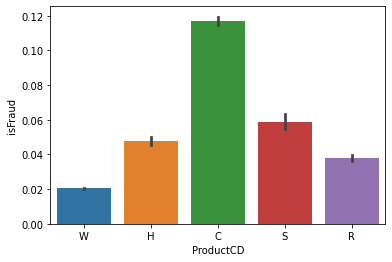

In [ ]:
sns.barplot(x= categorical['ProductCD'],y=numerical['isFraud'])

Thấy có correlation, nên sử dụng One Hot Encoder với ProductCD

### **card4** ###

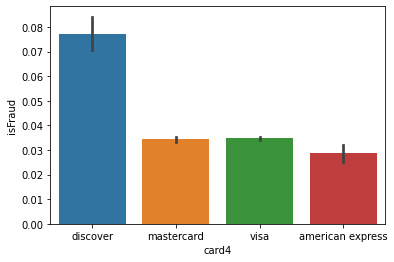

In [ ]:
sns.barplot(x= categorical['card4'],y=numerical['isFraud'])

### **card6** ###

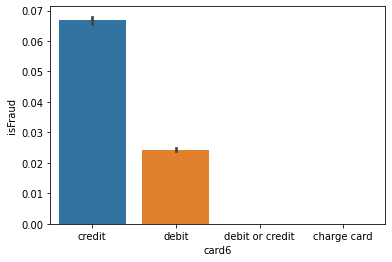

In [ ]:
sns.barplot(x= categorical['card6'],y=numerical['isFraud'])

### **M1** ###

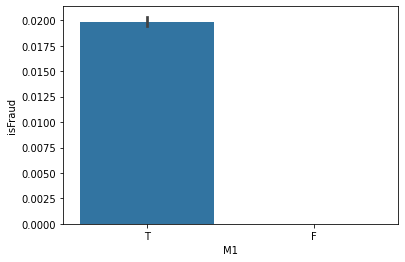

In [ ]:
sns.barplot(x= categorical['M1'],y=numerical['isFraud'])

### **M2** ###

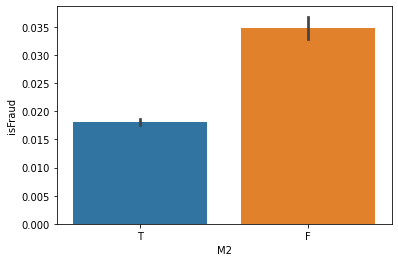

In [ ]:
sns.barplot(x= categorical['M2'],y=numerical['isFraud'])

### **M3** ###

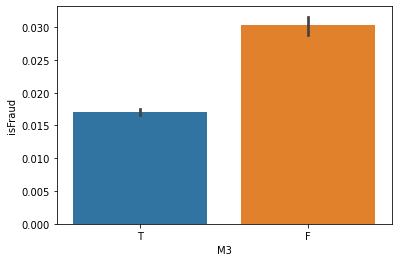

In [ ]:
sns.barplot(x= categorical['M3'],y=numerical['isFraud'])

### **P_emaildomain**###

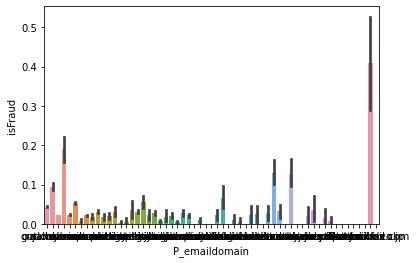

In [ ]:
sns.barplot(x= categorical['P_emaildomain'],y=numerical['isFraud'])

### **R_emaildomain** ###

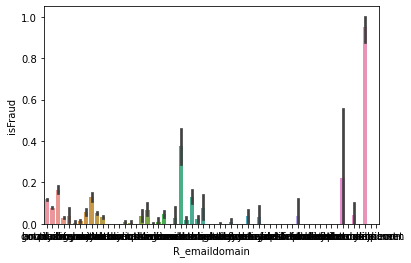

In [ ]:
sns.barplot(x= categorical['R_emaildomain'],y=numerical['isFraud'])

### **DeviceType** ###

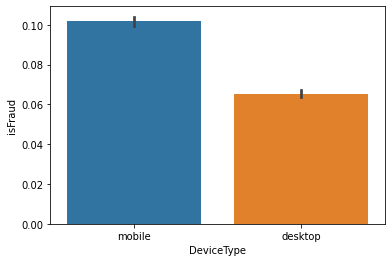

In [ ]:
sns.barplot(x= categorical['DeviceType'],y=numerical['isFraud'])

### **DeviceInfo** ###

In [ ]:
categorical['DeviceInfo'].value_counts()

Windows                          47722
iOS Device                       19782
MacOS                            12573
Trident/7.0                       7440
rv:11.0                           1901
                                 ...  
VK815                                1
ATT                                  1
LG-LS995                             1
SAMSUNG SM-J111M Build/LMY47V        1
VK810                                1
Name: DeviceInfo, Length: 1786, dtype: int64

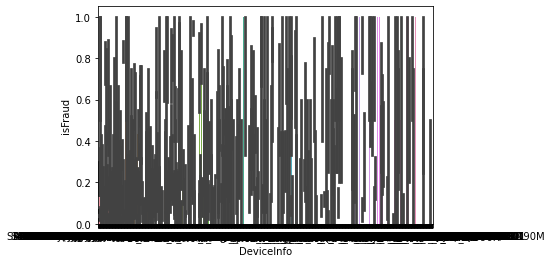

In [ ]:
sns.barplot(x= categorical['DeviceInfo'],y=numerical['isFraud'])

### **id_33** ###

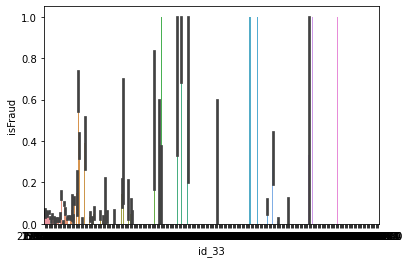

In [ ]:
sns.barplot(x= categorical['id_33'],y=numerical['isFraud'])

# **3. Feature Engineering**

### **Kết hợp Train và Test lại để xử lý dữ liệu** ###

In [ ]:
ntrain = final_train.shape[0]
ntest = final_test.shape[0]
all_data = pd.concat([final_train, final_test], axis = 0, sort = False)

In [ ]:
all_data = all_data.drop(columns=['isFraud'])

In [ ]:
#del numerical
#del categorical
del final_train
del final_test

In [ ]:
all_data

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             2987000          86400       68.500000         W  13926    NaN   
1             2987001          86401       29.000000         W   2755  404.0   
2             2987002          86469       59.000000         W   4663  490.0   
3             2987003          86499       50.000000         W  18132  567.0   
4             2987004          86506       50.000000         H   4497  514.0   
...               ...            ...             ...       ...    ...    ...   
506686        4170235       34214279       94.687500         C  13832  375.0   
506687        4170236       34214287       12.171875         C   3154  408.0   
506688        4170237       34214326       49.000000         W  16661  490.0   
506689        4170238       34214337      202.000000         W  16621  516.0   
506690        4170239       34214345       24.343750         C   5713  168.0   

        card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0       150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1       150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2       150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3       150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4       150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   
...       ...         ...    ...     ...    ...    ...    ...    ...   
506686  185.0  mastercard  224.0   debit  284.0   60.0    NaN    NaN   
506687  185.0  mastercard  224.0   debit    NaN    NaN    NaN  157.0   
506688  150.0        visa  226.0   debit  327.0   87.0    NaN    NaN   
506689  150.0  mastercard  224.0   debit  177.0   87.0    NaN    NaN   
506690  144.0        visa  147.0  credit    NaN    NaN    NaN    NaN   

       P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8  \
0                NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
1          gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
2        outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
3          yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0   
4          gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   
...              ...           ...  ...  ...  ...  ...  ...  ...  ...  ...   
506686     gmail.com     gmail.com  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   
506687   hotmail.com   hotmail.com  1.0  3.0  0.0  1.0  0.0  1.0  1.0  2.0   
506688   hotmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
506689   hotmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
506690   hotmail.com   hotmail.com  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0   

         C9  C10  C11  C12   C13  C14     D1     D2    D3    D4    D5    D6  \
0       1.0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN   NaN   NaN   
1       0.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0   NaN   NaN   
2       1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0   NaN   NaN   
3       1.0  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0   0.0   NaN   
4       0.0  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN   NaN   NaN   
...     ...  ...  ...  ...   ...  ...    ...    ...   ...   ...   ...   ...   
506686  0.0  0.0  1.0  1.0   1.0  1.0    0.0    NaN   NaN   0.0   NaN   0.0   
506687  0.0  2.0  1.0  1.0   3.0  1.0   16.0   16.0  16.0  16.0  16.0  16.0   
506688  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0   NaN   NaN   
506689  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0   NaN   NaN   
506690  0.0  1.0  1.0  1.0   1.0  1.0    0.0    NaN   NaN   0.0   NaN   0.0   

          D7         D8        D9   D10    D11   D12  D13  D14    D15   M1  \
0        NaN        NaN       NaN  13.0   13.0   NaN  NaN  NaN    0.0    T   
1        NaN        NaN       NaN   0.0    NaN   NaN  NaN  NaN    0.0  NaN   
2        NaN        NaN       NaN   0.0  315.0   NaN  NaN  NaN

### **Giảm kích thước dữ liệu** ###

In [ ]:
n = (all_data.dtypes != 'object')

num_all_cols = list(n[n].index) 

In [ ]:
num_cols_to_shrink_all = detect_num_cols_to_shrink(num_all_cols, all_data)

convert_to_int8 = num_cols_to_shrink_all[0]
convert_to_int16 = num_cols_to_shrink_all[1]
convert_to_int32 = num_cols_to_shrink_all[2]

convert_to_float16 = num_cols_to_shrink_all[3]
convert_to_float32 = num_cols_to_shrink_all[4]

In [ ]:
print("starting with converting process....")

for col in convert_to_int16:
    
    all_data[col] = all_data[col].astype('int16') 
    
for col in convert_to_int32:
    all_data[col] = all_data[col].astype('int32') 

for col in convert_to_float16:
    all_data[col] = all_data[col].astype('float16')
    
for col in convert_to_float32:
    all_data[col] = all_data[col].astype('float32')
    
print("successfully converted!")

starting with converting process....
successfully converted!


### **Chọn Features** ###

giải thích..

#### **Rút gọn các cột Vxx có correlation hơn 75%** ####

In [ ]:
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
v += [332, 325, 335, 338] # b4 lots NAN
cols = ['V'+str(x) for x in v]
for i in all_data.columns:
    if (i.startswith("V")) and i not in cols:
        all_data = all_data.drop(columns=[i])

In [ ]:
cols = list(all_data.columns)

In [ ]:
cols

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V96',
 'V98',
 'V99',
 'V104',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V160',
 'V162',
 'V165',
 'V16

giải thích.. dùng adverisal validation

### **One Hot Encode ProductCD, card6** ###

In [ ]:
a = all_data[['ProductCD','card6']]
a = pd.get_dummies(all_data[['ProductCD','card6']])

In [ ]:
a

ProductCD_C  ProductCD_H  ProductCD_R  ProductCD_S  ProductCD_W  \
0                 0            0            0            0            1   
1                 0            0            0            0            1   
2                 0            0            0            0            1   
3                 0            0            0            0            1   
4                 0            1            0            0            0   
...             ...          ...          ...          ...          ...   
506686            1            0            0            0            0   
506687            1            0            0            0            0   
506688            0            0            0            0            1   
506689            0            0            0            0            1   
506690            1            0            0            0            0   

        card6_charge card  card6_credit  card6_debit  card6_debit or credit  
0                       0             1            0                      0  
1                       0             1            0                      0  
2                       0             0            1                      0  
3                       0             0            1                      0  
4                       0             1            0                      0  
...                   ...           ...          ...                    ...  
506686                  0             0            1                      0  
506687                  0             0            1                      0  
506688                  0             0            1                      0  
506689                  0             0            1                      0  
506690                  0             1            0                      0  

[1097231 rows x 9 columns]

In [ ]:
all_data = pd.concat([all_data,a],axis=1)

In [ ]:
all_data = all_data.drop(columns='ProductCD')

In [ ]:
all_data

TransactionID  TransactionDT  TransactionAmt  card1  card2  card3  \
0             2987000          86400       68.500000  13926    NaN  150.0   
1             2987001          86401       29.000000   2755  404.0  150.0   
2             2987002          86469       59.000000   4663  490.0  150.0   
3             2987003          86499       50.000000  18132  567.0  150.0   
4             2987004          86506       50.000000   4497  514.0  150.0   
...               ...            ...             ...    ...    ...    ...   
506686        4170235       34214279       94.687500  13832  375.0  185.0   
506687        4170236       34214287       12.171875   3154  408.0  185.0   
506688        4170237       34214326       49.000000  16661  490.0  150.0   
506689        4170238       34214337      202.000000  16621  516.0  150.0   
506690        4170239       34214345       24.343750   5713  168.0  144.0   

             card4  card5   card6  addr1  addr2  dist1  dist2 P_emaildomain  \
0         discover  142.0  credit  315.0   87.0   19.0    NaN           NaN   
1       mastercard  102.0  credit  325.0   87.0    NaN    NaN     gmail.com   
2             visa  166.0   debit  330.0   87.0  287.0    NaN   outlook.com   
3       mastercard  117.0   debit  476.0   87.0    NaN    NaN     yahoo.com   
4       mastercard  102.0  credit  420.0   87.0    NaN    NaN     gmail.com   
...            ...    ...     ...    ...    ...    ...    ...           ...   
506686  mastercard  224.0   debit  284.0   60.0    NaN    NaN     gmail.com   
506687  mastercard  224.0   debit    NaN    NaN    NaN  157.0   hotmail.com   
506688        visa  226.0   debit  327.0   87.0    NaN    NaN   hotmail.com   
506689  mastercard  224.0   debit  177.0   87.0    NaN    NaN   hotmail.com   
506690        visa  147.0  credit    NaN    NaN    NaN    NaN   hotmail.com   

       R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  \
0                NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0   
1                NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
2                NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   
3                NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0   
4                NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
506686     gmail.com  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0   
506687   hotmail.com  1.0  3.0  0.0  1.0  0.0  1.0  1.0  2.0  0.0  2.0  1.0   
506688           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   
506689           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   
506690   hotmail.com  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   

        C12   C13  C14     D1     D2    D3    D4    D5    D6    D7         D8  \
0       0.0   1.0  1.0   14.0    NaN  13.0   NaN   NaN   NaN   NaN        NaN   
1       0.0   1.0  1.0    0.0    NaN   NaN   0.0   NaN   NaN   NaN        NaN   
2       0.0   1.0  1.0    0.0    NaN   NaN   0.0   NaN   NaN   NaN        NaN   
3       0.0  25.0  1.0  112.0  112.0   0.0  94.0   0.0   NaN   NaN        NaN   
4       0.0   1.0  1.0    0.0    NaN   NaN   NaN   NaN   NaN   NaN        NaN   
...     ...   ...  ...    ...    ...   ...   ...   ...   ...   ...        ...   
506686  1.0   1.0  1.0    0.0    NaN   NaN   0.0   NaN   0.0   NaN        NaN   
506687  1.0   3.0  1.0   16.0   16.0  16.0  16.0  16.0  16.0  16.0        NaN   
506688  0.0   1.0  1.0    0.0    NaN   NaN   0.0   NaN   NaN   NaN        NaN   
506689  0.0   1.0  1.0    0.0    NaN   NaN   0.0   NaN   NaN   NaN        NaN   
506690  1.0   1.0  1.0    0.0    NaN   NaN   0.0   NaN   0.0   NaN  29.953125   

              D9   D10    D11   D12  D13  D14    D15   M1   M2   M3   M4   M5  \
0            NaN  13.0   13.0   NaN  NaN  NaN    0.0    T    T    T   M2    F   
1            NaN   0.0    NaN   NaN  NaN  NaN    0

### **Factorize các biến Categorical, Fill Nan tất cả bằng số ảo -999** ###

In [ ]:
for i,f in enumerate(all_data.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(all_data[f].dtype)=='category')|(all_data[f].dtype=='object'): 
        #df_comb = pd.concat([final_train[f],final_test[f]],axis=0)
        all_data[f],_ = all_data[f].factorize(sort=True)
        if all_data[f].max()>32000: print(f,'needs int32')
        all_data[f] = all_data[f].astype('int16')
        #final_test[f] = df_comb[len(final_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -999
    elif f not in ['TransactionAmt','TransactionDT']:
        #mn = np.min(all_data[f].min())
        #all_data[f] -= np.float32(mn)
        #final_test[f] -= np.float32(mn)
        all_data[f].fillna(-999,inplace=True)
        #final_test[f].fillna(-999,inplace=True)

In [ ]:
all_data

TransactionID  TransactionDT  TransactionAmt  card1  card2  card3  \
0             2987000          86400       68.500000  13926 -999.0  150.0   
1             2987001          86401       29.000000   2755  404.0  150.0   
2             2987002          86469       59.000000   4663  490.0  150.0   
3             2987003          86499       50.000000  18132  567.0  150.0   
4             2987004          86506       50.000000   4497  514.0  150.0   
...               ...            ...             ...    ...    ...    ...   
506686        4170235       34214279       94.687500  13832  375.0  185.0   
506687        4170236       34214287       12.171875   3154  408.0  185.0   
506688        4170237       34214326       49.000000  16661  490.0  150.0   
506689        4170238       34214337      202.000000  16621  516.0  150.0   
506690        4170239       34214345       24.343750   5713  168.0  144.0   

        card4  card5  card6  addr1  addr2  dist1  dist2  P_emaildomain  \
0           1  142.0      1  315.0   87.0   19.0 -999.0             -1   
1           2  102.0      1  325.0   87.0 -999.0 -999.0             16   
2           3  166.0      2  330.0   87.0  287.0 -999.0             35   
3           2  117.0      2  476.0   87.0 -999.0 -999.0             54   
4           2  102.0      1  420.0   87.0 -999.0 -999.0             16   
...       ...    ...    ...    ...    ...    ...    ...            ...   
506686      2  224.0      2  284.0   60.0 -999.0 -999.0             16   
506687      2  224.0      2 -999.0 -999.0 -999.0  157.0             19   
506688      3  226.0      2  327.0   87.0 -999.0 -999.0             19   
506689      2  224.0      2  177.0   87.0 -999.0 -999.0             19   
506690      3  147.0      1 -999.0 -999.0 -999.0 -999.0             19   

        R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  \
0                  -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0   
1                  -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
2                  -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   
3                  -1  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0   
4                  -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0   
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
506686             16  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0   
506687             19  1.0  3.0  0.0  1.0  0.0  1.0  1.0  2.0  0.0  2.0  1.0   
506688             -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   
506689             -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   
506690             19  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   

        C12   C13  C14     D1     D2     D3     D4     D5     D6     D7  \
0       0.0   1.0  1.0   14.0 -999.0   13.0 -999.0 -999.0 -999.0 -999.0   
1       0.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
2       0.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
3       0.0  25.0  1.0  112.0  112.0    0.0   94.0    0.0 -999.0 -999.0   
4       0.0   1.0  1.0    0.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
...     ...   ...  ...    ...    ...    ...    ...    ...    ...    ...   
506686  1.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0    0.0 -999.0   
506687  1.0   3.0  1.0   16.0   16.0   16.0   16.0   16.0   16.0   16.0   
506688  0.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
506689  0.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
506690  1.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0    0.0 -999.0   

                D8          D9    D10    D11    D12    D13    D14    D15  M1  \
0      -999.000000 -999.000000   13.0   13.0 -999.0 -999.0 -999.0    0.0   1   
1      -999.000000 -999.000000    0.0 -999.0 -999.0 -999.0 -999.0    0.0  -1   
2      -999.000000 -999.000000    0.0  315.0 -999.0 -999.0 -999.0  315.0   1   
3      -999.

### **Chia tập Train và Test** ###

In [ ]:
X_train = all_data[ : ntrain]
X_test = all_data[ntrain : ]

In [ ]:
del all_data

In [ ]:
train_transaction = pd.read_csv('/content/drive/My Drive/IEEE/train_transaction.csv')

In [ ]:
y_train = train_transaction['isFraud']

In [ ]:
del train_transaction

### **Đổi TransactionDT thành thời gian, mốc ở 30/11/2017** ###

In [ ]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 
X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 

### **Biến đổi LE, Aggetation...**###

In [ ]:
cols = list(X_train.columns)
cols.remove('TransactionDT')
cols.remove('TransactionID')

In [ ]:
# FAILED ADVERSARIAL VALIDATION
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)

In [ ]:
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [ ]:
encode_CB('card1','addr1')
#encode_CB('card1_addr1','P_emaildomain')

X_train['day'] =X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] =X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

card1_addr1 , 

In [ ]:
%%time
# FREQUENCY ENCODE UID
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],X_test,X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE 
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15
CPU times: user 2min 21s, sys: 3.35 s, total: 2min 24s
Wall time: 2min 24s


In [ ]:
cols_uid = list(X_train.columns)

In [ ]:
cols_uid.remove('day')
cols_uid.remove('uid')

In [ ]:
print(np.array(cols))
print(np.array(cols_uid))

['TransactionAmt' 'card1' 'card2' 'card3' 'card5' 'card6' 'addr1' 'addr2'
 'dist1' 'dist2' 'P_emaildomain' 'R_emaildomain' 'C1' 'C2' 'C4' 'C5' 'C6'
 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5'
 'D10' 'D11' 'D15' 'M1' 'M2' 'M3' 'M4' 'M6' 'M7' 'M8' 'M9' 'V1' 'V3' 'V4'
 'V6' 'V8' 'V11' 'V13' 'V14' 'V17' 'V20' 'V23' 'V26' 'V27' 'V30' 'V36'
 'V37' 'V40' 'V41' 'V44' 'V47' 'V48' 'V54' 'V56' 'V59' 'V62' 'V65' 'V67'
 'V68' 'V70' 'V76' 'V78' 'V80' 'V82' 'V86' 'V88' 'V89' 'V91' 'V96' 'V98'
 'V99' 'V104' 'V107' 'V108' 'V111' 'V115' 'V117' 'V120' 'V121' 'V123'
 'V124' 'V127' 'V129' 'V130' 'V136' 'V138' 'V139' 'V142' 'V147' 'V156'
 'V160' 'V162' 'V165' 'V166' 'V169' 'V171' 'V173' 'V175' 'V176' 'V178'
 'V180' 'V182' 'V185' 'V187' 'V188' 'V198' 'V203' 'V205' 'V207' 'V209'
 'V210' 'V215' 'V218' 'V220' 'V221' 'V223' 'V224' 'V226' 'V228' 'V229'
 'V234' 'V235' 'V238' 'V240' 'V250' 'V252' 'V253' 'V257' 'V258' 'V260'
 'V261' 'V264' 'V266' 'V267' 'V271' 'V274' 'V277' 'V281' 'V283' '

# **4. Xây dựng Model**

In [ ]:
#sử dụng CatBoostClassifier regressor
#model = LogisticRegression(solver='lbfgs',max_iter=10000)

#model = CatBoostClassifier()
model = xgb.XGBClassifier(
            n_estimators=1000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist' 
        #tree_method='gpu_hist' 
                           )

## **No UID** ##

In [ ]:
X_test.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
card1             0
card2             0
                 ..
uid_V136_ct       0
uid_V309_ct       0
uid_V307_ct       0
uid_V320_ct       0
outsider15        0
Length: 282, dtype: int64

In [ ]:
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [ ]:
print(idxT.shape)
print(idxV.shape)

(442905,)
(147635,)


In [ ]:
X_train

TransactionID  TransactionDT  TransactionAmt  card1  card2  card3  \
0             2987000          86400       68.500000  13926 -999.0  150.0   
1             2987001          86401       29.000000   2755  404.0  150.0   
2             2987002          86469       59.000000   4663  490.0  150.0   
3             2987003          86499       50.000000  18132  567.0  150.0   
4             2987004          86506       50.000000   4497  514.0  150.0   
...               ...            ...             ...    ...    ...    ...   
590535        3577535       15811047       49.000000   6550 -999.0  150.0   
590536        3577536       15811049       39.500000  10444  225.0  150.0   
590537        3577537       15811079       30.953125  12037  595.0  150.0   
590538        3577538       15811088      117.000000   7826  481.0  150.0   
590539        3577539       15811131      280.000000  15066  170.0  150.0   

        card4  card5  card6  addr1  addr2  dist1  dist2  P_emaildomain  \
0           1  142.0      1  315.0   87.0   19.0 -999.0             -1   
1           2  102.0      1  325.0   87.0 -999.0 -999.0             16   
2           3  166.0      2  330.0   87.0  287.0 -999.0             35   
3           2  117.0      2  476.0   87.0 -999.0 -999.0             54   
4           2  102.0      1  420.0   87.0 -999.0 -999.0             16   
...       ...    ...    ...    ...    ...    ...    ...            ...   
590535      3  226.0      2  272.0   87.0   48.0 -999.0             -1   
590536      2  224.0      2  204.0   87.0 -999.0 -999.0             16   
590537      2  224.0      2  231.0   87.0 -999.0 -999.0             16   
590538      2  224.0      2  387.0   87.0    3.0 -999.0              2   
590539      2  102.0      1  299.0   87.0 -999.0 -999.0             16   

        R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  \
0                  -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0   
1                  -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
2                  -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   
3                  -1  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0   
4                  -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0   
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
590535             -1  2.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  2.0  0.0  1.0   
590536             -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   
590537             -1  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0   
590538             -1  1.0  1.0  0.0  0.0  0.0  3.0  0.0  0.0  2.0  0.0  1.0   
590539             -1  2.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  1.0   

        C12   C13  C14     D1     D2     D3     D4     D5     D6     D7  \
0       0.0   1.0  1.0   14.0 -999.0   13.0 -999.0 -999.0 -999.0 -999.0   
1       0.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
2       0.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
3       0.0  25.0  1.0  112.0  112.0    0.0   94.0    0.0 -999.0 -999.0   
4       0.0   1.0  1.0    0.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
...     ...   ...  ...    ...    ...    ...    ...    ...    ...    ...   
590535  0.0   3.0  2.0   29.0   29.0   30.0 -999.0 -999.0 -999.0 -999.0   
590536  0.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
590537  0.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
590538  1.0   5.0  1.0   22.0   22.0    0.0   22.0    0.0 -999.0 -999.0   
590539  0.0   1.0  1.0    0.0 -999.0    0.0    1.0    0.0 -999.0 -999.0   

           D8     D9    D10    D11    D12    D13    D14    D15  M1  M2  M3  \
0      -999.0 -999.0   13.0   13.0 -999.0 -999.0 -999.0    0.0   1   1   1   
1      -999.0 -999.0    0.0 -999.0 -999.0 -999.0 -999.0    0.0  -1  -1  -1   
2      -999.0 -999.0    0.0  315.0 -999.0 -999.0 -999.0  315.0   1   1   1   
3      -999.0 -999.0

In [ ]:
X_test

TransactionID  TransactionDT  TransactionAmt  card1  card2  card3  \
0             3663549       18403224       31.953125  10409  111.0  150.0   
1             3663550       18403263       49.000000   4272  111.0  150.0   
2             3663551       18403310      171.000000   4476  574.0  150.0   
3             3663552       18403310      285.000000  10989  360.0  150.0   
4             3663553       18403317       67.937500  18018  452.0  150.0   
...               ...            ...             ...    ...    ...    ...   
506686        4170235       34214279       94.687500  13832  375.0  185.0   
506687        4170236       34214287       12.171875   3154  408.0  185.0   
506688        4170237       34214326       49.000000  16661  490.0  150.0   
506689        4170238       34214337      202.000000  16621  516.0  150.0   
506690        4170239       34214345       24.343750   5713  168.0  144.0   

        card4  card5  card6  addr1  addr2   dist1  dist2  P_emaildomain  \
0           3  226.0      2  170.0   87.0     1.0 -999.0             16   
1           3  226.0      2  299.0   87.0     4.0 -999.0              2   
2           3  226.0      2  472.0   87.0  2636.0 -999.0             19   
3           3  166.0      2  205.0   87.0    17.0 -999.0             16   
4           2  117.0      2  264.0   87.0     6.0 -999.0             16   
...       ...    ...    ...    ...    ...     ...    ...            ...   
506686      2  224.0      2  284.0   60.0  -999.0 -999.0             16   
506687      2  224.0      2 -999.0 -999.0  -999.0  157.0             19   
506688      3  226.0      2  327.0   87.0  -999.0 -999.0             19   
506689      2  224.0      2  177.0   87.0  -999.0 -999.0             19   
506690      3  147.0      1 -999.0 -999.0  -999.0 -999.0             19   

        R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  \
0                  -1  6.0  6.0  0.0  0.0  3.0  4.0  0.0  0.0  6.0  0.0  5.0   
1                  -1  3.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  2.0  0.0  1.0   
2                  -1  2.0  2.0  0.0  0.0  0.0  5.0  0.0  0.0  4.0  0.0  2.0   
3                  -1  5.0  2.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  2.0   
4                  -1  6.0  6.0  0.0  0.0  2.0  5.0  0.0  0.0  5.0  0.0  6.0   
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
506686             16  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0   
506687             19  1.0  3.0  0.0  1.0  0.0  1.0  1.0  2.0  0.0  2.0  1.0   
506688             -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   
506689             -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   
506690             19  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   

        C12    C13  C14     D1     D2     D3     D4     D5     D6     D7  \
0       1.0  115.0  6.0  419.0  419.0   27.0  398.0   27.0 -999.0 -999.0   
1       1.0   12.0  2.0  149.0  149.0    7.0  634.0    7.0 -999.0 -999.0   
2       0.0   22.0  2.0  137.0  137.0   10.0   97.0   10.0 -999.0 -999.0   
3       0.0    7.0  4.0   42.0   42.0   41.0  242.0   41.0 -999.0 -999.0   
4       0.0   14.0  6.0   22.0   22.0    0.0   22.0    0.0 -999.0 -999.0   
...     ...    ...  ...    ...    ...    ...    ...    ...    ...    ...   
506686  1.0    1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0    0.0 -999.0   
506687  1.0    3.0  1.0   16.0   16.0   16.0   16.0   16.0   16.0   16.0   
506688  0.0    1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
506689  0.0    1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
506690  1.0    1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0    0.0 -999.0   

                D8          D9    D10    D11    D12    D13    D14    D15  M1  \
0      -999.000000 -999.000000  418.0  203.0 -999.0 -999.0 -999.0  409.0   1   
1      -999.000000 -999.000000  231.0  634.0 -999.0 -999.0 -999.0  634.0   1   
2      -999.000000 -999.000000  136.0  136.0 -999.0 -999.0 -999.0   

In [ ]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 205 FEATURES.


array(['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V96', 'V98', 'V99', 'V104', 'V107', 'V108', 'V111', 'V115',
       'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 'V129', 'V130',
       'V136', 'V138', 'V139', 'V142', 'V147', 'V156', 'V160', 'V162',
       'V165', 'V166', 'V169', 'V171', 'V173', 'V175', 'V176', 'V178',
       'V180', 'V182', 'V185', 'V187', 'V188', 'V198', 'V203', 'V205',
       'V207', '

In [ ]:
y_train.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

## **Cách Validate:** ##
- Mục tiêu là dùng các transaction của hiện tại và quá khứ để đánh giá data của tương lai, **mốc thời gian** rất là quan trọng trong việc Validate
- Không nên xài cross validation, vì không kiểm soát được mốc thời gian

**=> Sử dụng Group KFold và Out of Fold Validation**

During the k-fold cross-validation process, predictions are made on test sets comprised of data not used to train the model. These predictions are referred to as out-of-fold predictions, a type of out-of-sample predictions.

You use group k-fold when you have groups you don't want split across the training and test sets. For example, if your data includes multiple rows for each customer (but it still makes sense to train on individual transactions/rows), and your production use-case involves making predictions for new customers, then testing on rows from customers that also have rows in your training set may be optimistically biased.


There is a nice trick to see what is causing the difference in scores between the training and the test data: Determining OOF (out-of-fold) scores. The OOF score is basically a score on unseen data but within the training data domain itself. It nicely controls for the effect of “out of domain” data.

Hướng dánh giá: train model theo tháng, rồi đánh giá out-of-fold score bằng cách cho model dự đoán các giao dịch tháng tiếp theo

In [ ]:
oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))
skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    clf = xgb.XGBClassifier(
            n_estimators=1000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist' 
        )        
    h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)
    
    oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
    preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        
print('#'*20)
print ('XGB96 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.741543
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.864382
[200]	validation_0-auc:0.883655
[300]	validation_0-auc:0.896149
[400]	validation_0-auc:0.902862
[500]	validation_0-auc:0.905404
[600]	validation_0-auc:0.9069
[700]	validation_0-auc:0.90729
[800]	validation_0-auc:0.906926
Stopping. Best iteration:
[670]	validation_0-auc:0.907471

Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.821842
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.892334
[200]	validation_0-auc:0.912123
[300]	validation_0-auc:0.924674
[400]	validation_0-auc:0.930617
[500]	validation_0-auc:0.932416
[600]	validation_0-auc:0.933534
[700]	validation_0-auc:0.933815
[800]	validation_0-auc:0.933612
[900]	validation_0-auc:0.933314
Stopping. Best iteration:
[717]	validation_0-auc:0.93389

## **UID Magic:** ##
Theo ban tổ chức cuộc thi, mục đích của cuộc thi là không chỉ là tìm các giao dịch lừa đảo qua thời gian mà là đoán phần trăm các khách hàng mà có khả năng lừa đảo. Từ đó tất cả thông tin về khách hàng: số thẻ, địa chỉ, tên... sẽ được dán nhãn là lừa đảo. Vậy nên 1 trong các hướng khiến model tốt hơn là tạo các features giúp phân biệt các khách hàng dễ hơn

UID (Unique Identification Data), là những features được biến đổi nhằm phân biệt các khách hàng dễ dàng hơn.

UID càng dễ phân biệt giữa 2 khách A và B thì sẽ có chất lượng tốt hơn

Qua sự tìm hiểu của tkravichandran (top 1 cuộc thi), anh đã đưa ra 1 số biến thể UID để so sánh và chọn ra UID tốt nhất. Trong notebook này sẽ không đi sâu vào phần kiếm UID, link tham khảo: .... 

In [ ]:
X_train

TransactionID  TransactionDT  TransactionAmt  card1  card2  card3  \
0             2987000          86400       68.500000  13926 -999.0  150.0   
1             2987001          86401       29.000000   2755  404.0  150.0   
2             2987002          86469       59.000000   4663  490.0  150.0   
3             2987003          86499       50.000000  18132  567.0  150.0   
4             2987004          86506       50.000000   4497  514.0  150.0   
...               ...            ...             ...    ...    ...    ...   
590535        3577535       15811047       49.000000   6550 -999.0  150.0   
590536        3577536       15811049       39.500000  10444  225.0  150.0   
590537        3577537       15811079       30.953125  12037  595.0  150.0   
590538        3577538       15811088      117.000000   7826  481.0  150.0   
590539        3577539       15811131      280.000000  15066  170.0  150.0   

        card4  card5  card6  addr1  addr2  dist1  dist2  P_emaildomain  \
0           1  142.0      1  315.0   87.0   19.0 -999.0             -1   
1           2  102.0      1  325.0   87.0 -999.0 -999.0             16   
2           3  166.0      2  330.0   87.0  287.0 -999.0             35   
3           2  117.0      2  476.0   87.0 -999.0 -999.0             54   
4           2  102.0      1  420.0   87.0 -999.0 -999.0             16   
...       ...    ...    ...    ...    ...    ...    ...            ...   
590535      3  226.0      2  272.0   87.0   48.0 -999.0             -1   
590536      2  224.0      2  204.0   87.0 -999.0 -999.0             16   
590537      2  224.0      2  231.0   87.0 -999.0 -999.0             16   
590538      2  224.0      2  387.0   87.0    3.0 -999.0              2   
590539      2  102.0      1  299.0   87.0 -999.0 -999.0             16   

        R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  \
0                  -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0   
1                  -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
2                  -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   
3                  -1  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0   
4                  -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0   
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
590535             -1  2.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  2.0  0.0  1.0   
590536             -1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   
590537             -1  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0   
590538             -1  1.0  1.0  0.0  0.0  0.0  3.0  0.0  0.0  2.0  0.0  1.0   
590539             -1  2.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  1.0   

        C12   C13  C14     D1     D2     D3     D4     D5     D6     D7  \
0       0.0   1.0  1.0   14.0 -999.0   13.0 -999.0 -999.0 -999.0 -999.0   
1       0.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
2       0.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
3       0.0  25.0  1.0  112.0  112.0    0.0   94.0    0.0 -999.0 -999.0   
4       0.0   1.0  1.0    0.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
...     ...   ...  ...    ...    ...    ...    ...    ...    ...    ...   
590535  0.0   3.0  2.0   29.0   29.0   30.0 -999.0 -999.0 -999.0 -999.0   
590536  0.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
590537  0.0   1.0  1.0    0.0 -999.0 -999.0    0.0 -999.0 -999.0 -999.0   
590538  1.0   5.0  1.0   22.0   22.0    0.0   22.0    0.0 -999.0 -999.0   
590539  0.0   1.0  1.0    0.0 -999.0    0.0    1.0    0.0 -999.0 -999.0   

           D8     D9    D10    D11    D12    D13    D14    D15  M1  M2  M3  \
0      -999.0 -999.0   13.0   13.0 -999.0 -999.0 -999.0    0.0   1   1   1   
1      -999.0 -999.0    0.0 -999.0 -999.0 -999.0 -999.0    0.0  -1  -1  -1   
2      -999.0 -999.0    0.0  315.0 -999.0 -999.0 -999.0  315.0   1   1   1   
3      -999.0 -999.0

In [ ]:
cols_uid.remove('TransactionID')

In [ ]:
print('NOW USING THE FOLLOWING',len(cols_uid),'FEATURES.')
np.array(cols_uid)

NOW USING THE FOLLOWING 278 FEATURES.


array(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3',
       'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2',
       'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5',
       'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1',
       'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
       'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6',
       'M7', 'M8', 'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13',
       'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37',
       'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62',
       'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86',
       'V88', 'V89', 'V91', 'V96', 'V98', 'V99', 'V104', 'V107', 'V108',
       'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127',
       'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156',
       'V160', 'V162', 'V165', 'V166', 'V169', 'V171', 'V173', 'V175',
       'V176'

In [ ]:
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [ ]:
oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))
skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    clfz = xgb.XGBClassifier(
            n_estimators=1000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist' 
        )        
    hz = clfz.fit(X_train[cols_uid].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols_uid].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)
    
    oof[idxV] += clfz.predict_proba(X_train[cols_uid].iloc[idxV])[:,1]
    preds += clfz.predict_proba(X_test[cols_uid])[:,1]/skf.n_splits
        
print('#'*20)
print ('XGB96 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.793196
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.895942
[200]	validation_0-auc:0.916835
[300]	validation_0-auc:0.925166
[400]	validation_0-auc:0.929727
[500]	validation_0-auc:0.93131
[600]	validation_0-auc:0.932164
[700]	validation_0-auc:0.932135
[800]	validation_0-auc:0.932574
[900]	validation_0-auc:0.932294
Stopping. Best iteration:
[779]	validation_0-auc:0.9326

Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.836081
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.923592
[200]	validation_0-auc:0.944166
[300]	validation_0-auc:0.953385
[400]	validation_0-auc:0.956668
[500]	validation_0-auc:0.957669
[600]	validation_0-auc:0.957914
[700]	validation_0-auc:0.95816
[800]	validation_0-auc:0.958152
[900]	validation_0-auc:0.957712
Stopping. Best iteration:

Như ta có thể thấy giữa 2 model No UID (93%) và UID (95.6%) có tăng về độ chính xác

<BarContainer object of 278 artists>

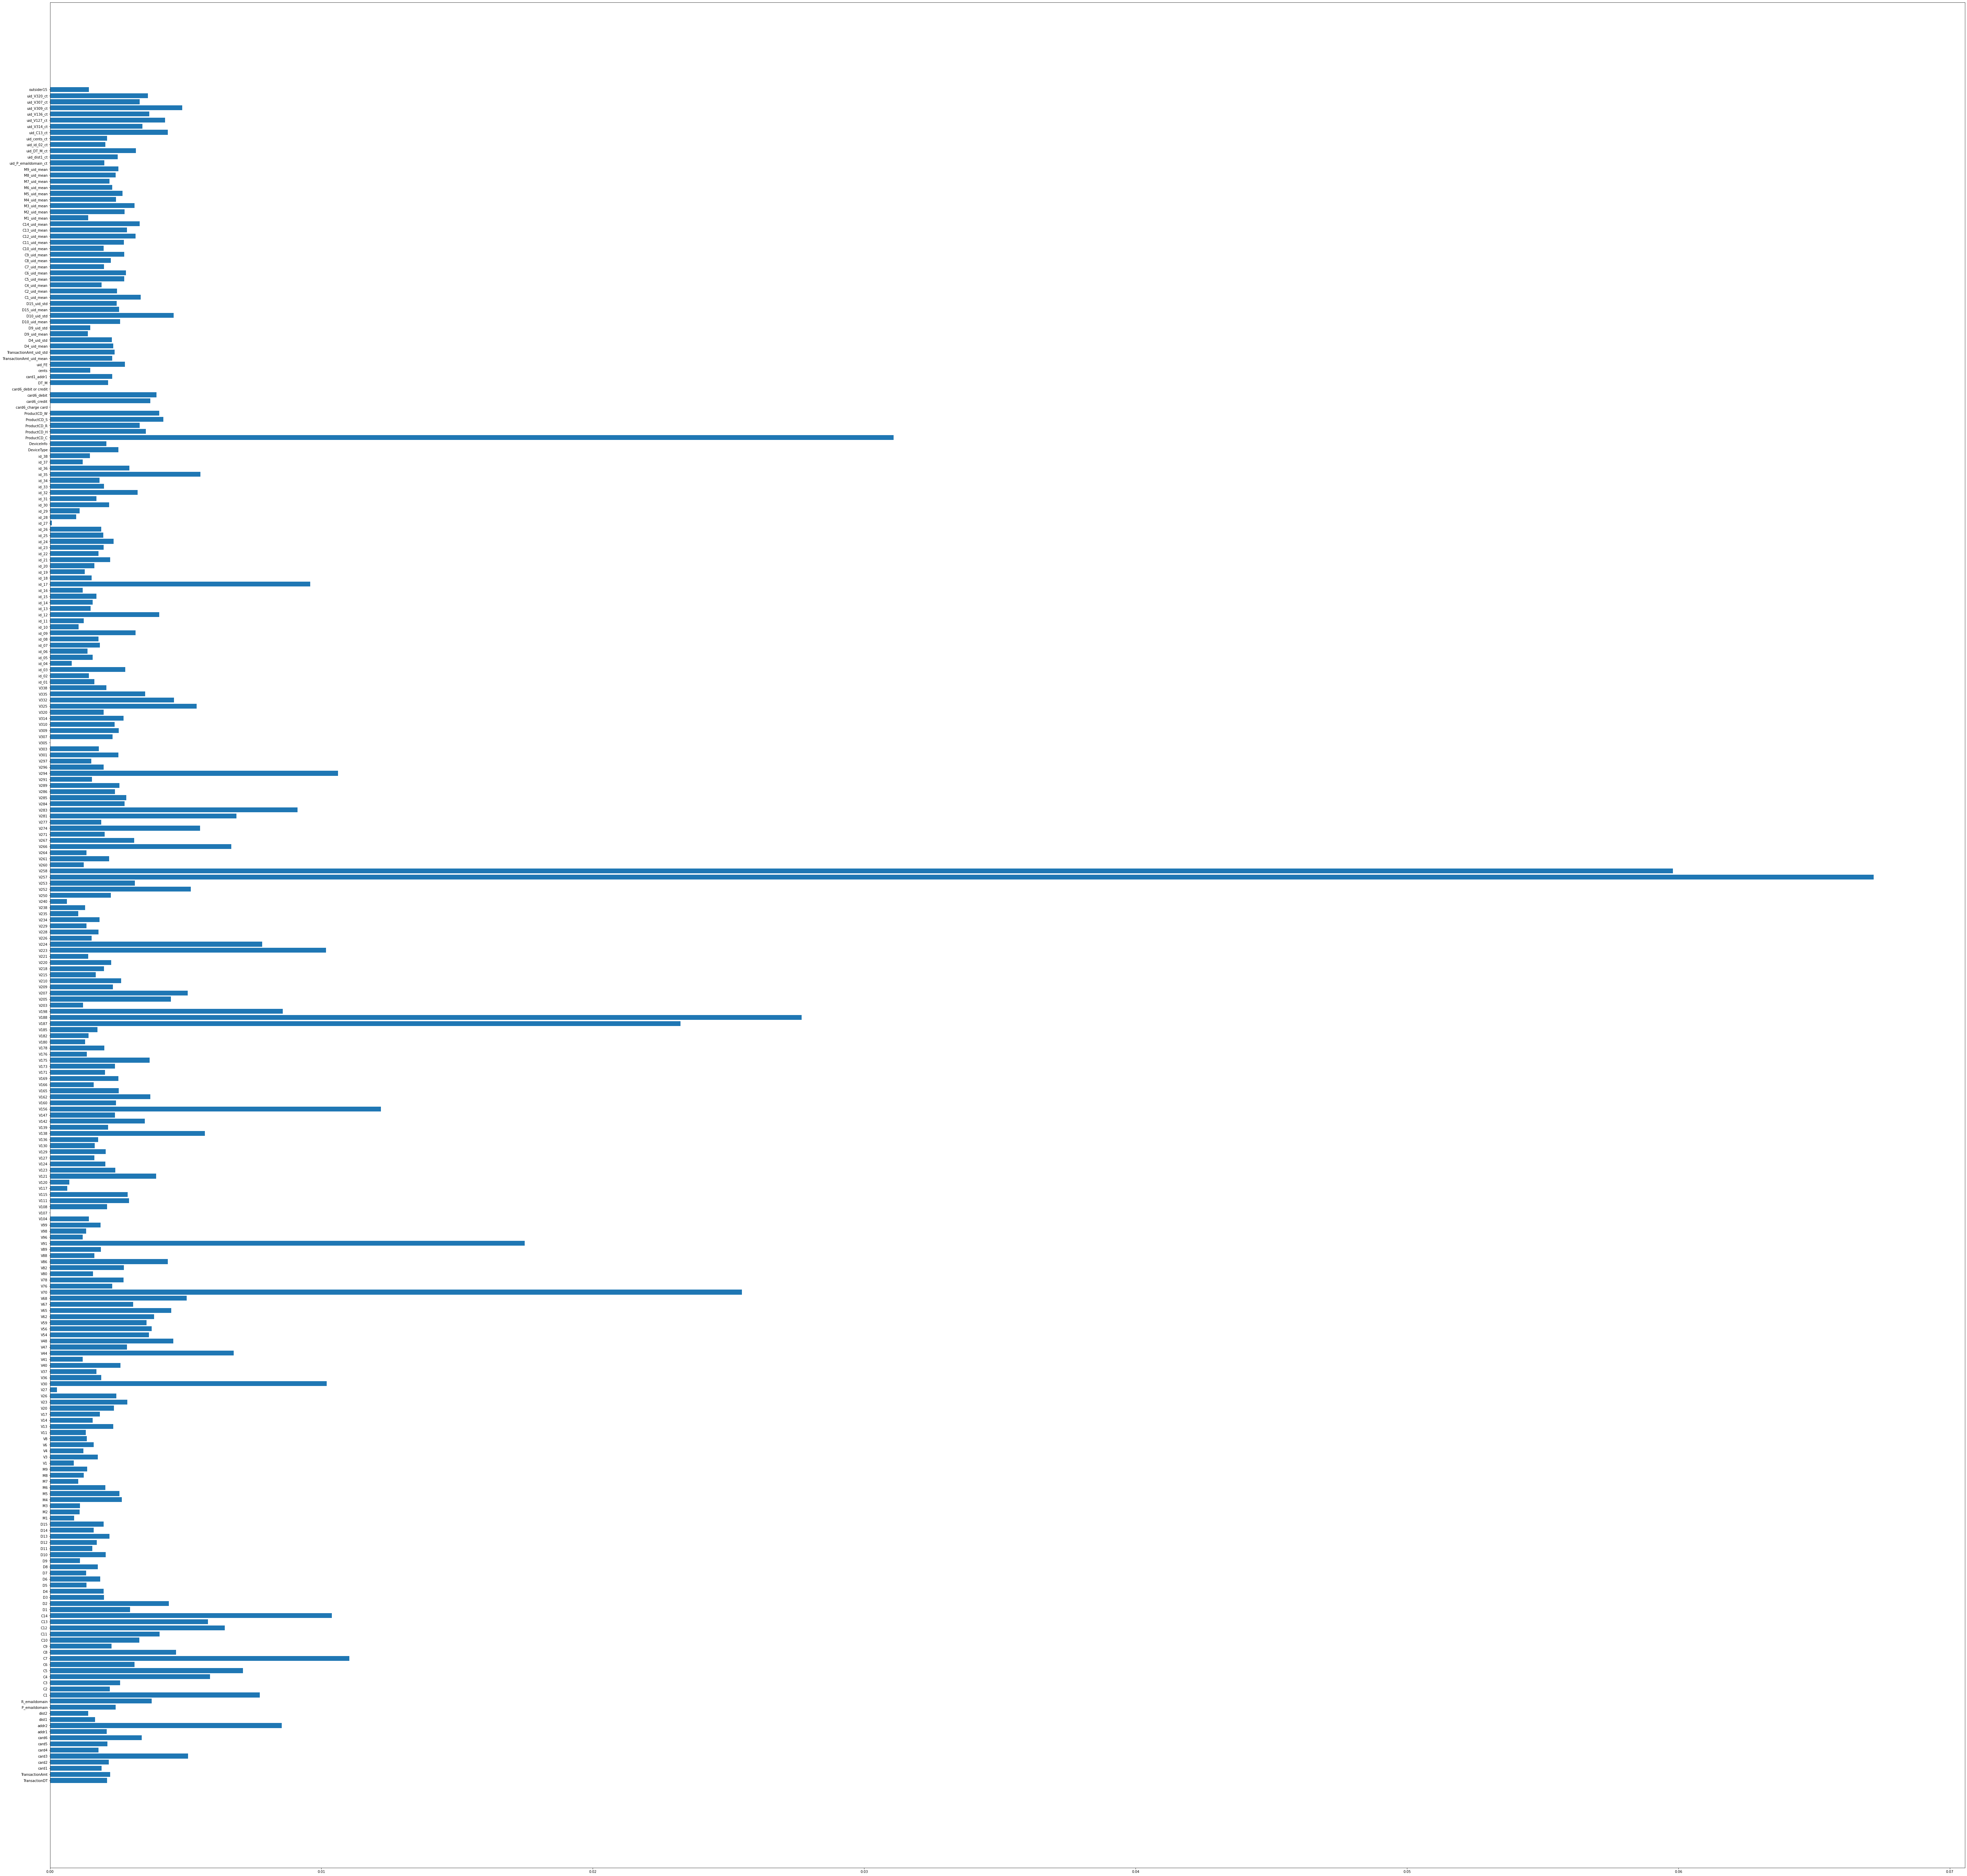

In [ ]:
clfz.feature_importances_
plt.figure(figsize=(100,100))
plt.barh(cols_uid, clfz.feature_importances_)

##**The Adversarial validation.**##

Mình sẽ tạo 1 model và cho nó phân biệt tập train và tập test được không. Nếu có, model sẽ cho ta biết sự quan trọng giữa các features và cách sử dụng nó

In [ ]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
TARGET    = 'target'   # Our Target
SEED      = 42         # Base SEED
N_SPLITS  = 2          # Number of Kfold Splits
PATH      = '/content/drive/My Drive/IEEE/'
train_df = pd.read_csv(PATH+'train_transaction.csv')
test_df  = pd.read_csv(PATH+'test_transaction.csv')
train_df[TARGET] = 1
test_df[TARGET]  = 0
del train_df['isFraud']

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)
del all_df['TransactionDT'], all_df['TransactionID'] # obvious "leakers"

del train_df, test_df

for col in list(all_df):
    if all_df[col].dtype=='O':
        all_df[col] = all_df[col].astype('category')

In [ ]:
lgb_params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'n_estimators': 200,
                'learning_rate': 0.05,
                'num_leaves': 2**7,
                'min_data_in_leaf': 2**8,
                'feature_fraction': 0.7,
                'subsample': 0.7,
                'subsample_freq': 1,
                'early_stopping_rounds': 100,
                'boost_from_average': True,
                'seed': SEED,
                'verbose': -1
            }

In [ ]:
features_columns = [col for col in list(all_df) if col not in [TARGET]]
folds = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
all_df['preds'] = 0
for fold_, (trn_idx, val_idx) in enumerate(folds.split(all_df[TARGET],all_df[TARGET])):
    print('Fold:',fold_+1)
    train_data = lgb.Dataset(all_df[features_columns].iloc[trn_idx,:], 
                             label=all_df[TARGET][trn_idx])
    valid_data = lgb.Dataset(all_df[features_columns].iloc[val_idx,:], 
                             label=all_df[TARGET][val_idx])
    estimator = lgb.train(lgb_params,train_data,
                          valid_sets = [train_data,valid_data],
                          verbose_eval = 100)
    all_df.iloc[val_idx, len(list(all_df))-1] += (estimator.predict(all_df[features_columns].iloc[val_idx,:])) 
    break # we will run only 1 fold - hust for fast check
    
print(roc_auc_score(all_df[TARGET], all_df['preds']))

In [ ]:
folds = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# Separate train features and target
X,y   = all_df[features_columns], all_df[TARGET]

# Create column to store predictions
all_df['preds'] = 0

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X,y)):
        
    print('Fold:',fold_+1)
        
    # Creating lgb train/valid data
    tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx] 
    vl_x, vl_y = X.iloc[val_idx,:], y[val_idx] 
        
    train_data = lgb.Dataset(tr_x, label=tr_y)
    valid_data = lgb.Dataset(vl_x, label=vl_y)
        
    # Train Model
    seed_everything(SEED)
    estimator = lgb.train(
                          lgb_params,
                          train_data,
                          valid_sets = [train_data,valid_data],
                          verbose_eval = 100,
                        )
        
    all_df.iloc[val_idx, len(list(all_df))-1] += (estimator.predict(vl_x)) 

print(roc_auc_score(all_df[TARGET], all_df['preds']))

In [ ]:
lgb.plot_importance(estimator, figsize=(10,100))